Here we should make sure that our Transformer implementation works properly. For this purpose we gonna learn to translate on En-De pair

In [1]:
import sys; sys.path += ['..', '../src']

In [2]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'
max_len = 50 # Processing long sentences is slow

train_src_path = os.path.join(DATA_PATH, 'train.en.tok.bpe')
train_trg_path = os.path.join(DATA_PATH, 'train.de.tok.bpe')
val_src_path = os.path.join(DATA_PATH, 'val.en.tok.bpe')
val_trg_path = os.path.join(DATA_PATH, 'val.de.tok.bpe')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

train_src = [s.split()[:max_len-2] for s in train_src]
train_trg = [s.split()[:max_len-2] for s in train_trg]
val_src = [s.split()[:max_len-2] for s in val_src]
val_trg = [s.split()[:max_len-2] for s in val_trg]

vocab_src = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.en'))
vocab_trg = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.de'))

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]
val_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in val_src]
val_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in val_trg]

In [16]:
from src.transformer.models import Transformer

model = Transformer(
    len(vocab_src),
    len(vocab_trg),
    max_len,
    n_layers=6,
    n_head=8,
    d_word_vec=512,
    d_model=512,
    d_inner_hid=2048,
    d_k=64,
    d_v=64)

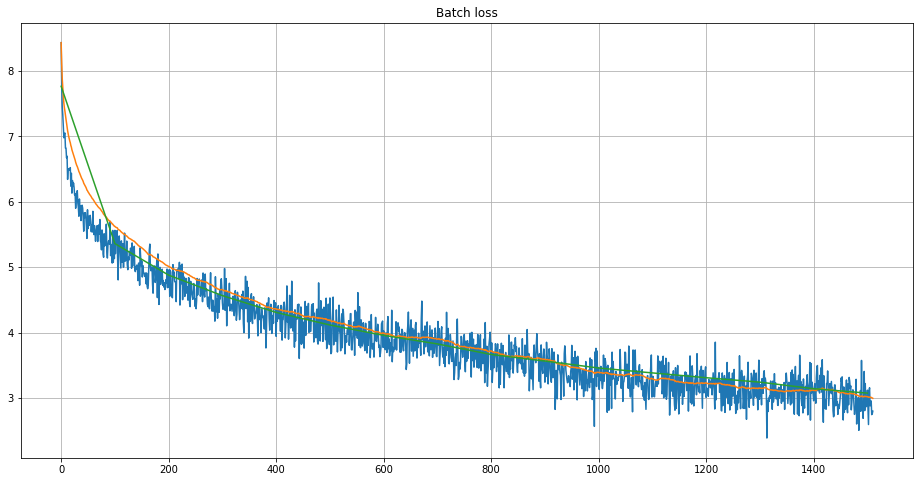

KeyboardInterrupt: 

In [17]:
import math
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
tqdm.monitor_interval = 0

from src.utils.data_utils import Batcher
import src.transformer.constants as constants

use_cuda = torch.cuda.is_available()


def get_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0
    
    if use_cuda: weight = weight.cuda()

    return nn.CrossEntropyLoss(weight)

optimizer = Adam(model.get_trainable_parameters(), lr=1e-4, betas=(0.9, 0.98))
criterion = get_criterion(len(vocab_trg))
training_data = Batcher(train_src_idx, train_trg_idx, vocab_src.token2id,
                        vocab_trg.token2id, batch_size=32, shuffle=True)
val_data = Batcher(val_src_idx, val_trg_idx, vocab_src.token2id,
                   vocab_trg.token2id, batch_size=32, shuffle=True)

if use_cuda:
    model.cuda()
    criterion.cuda()

model.train()
loss_history = []
val_loss_history = []
val_loss_iters = []
num_iters_done = 0

for i in range(10):
    for batch in tqdm(training_data, leave=False):
        src, tgt = batch
        optimizer.zero_grad()
        pred = model(src, tgt)
        loss = criterion(pred, tgt[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()

        loss_history.append(loss.data[0])

        if num_iters_done % 5 == 0:
            clear_output(True)
            plt.figure(figsize=[16,8])
            plt.title("Batch loss")
            plt.plot(loss_history)
            plt.plot(pd.DataFrame(np.array(loss_history)).ewm(span=100).mean())
            plt.plot(val_loss_iters, val_loss_history)
            plt.grid()
            plt.show()
            
        if num_iters_done % 100 == 0:
            val_losses = []
            for val_batch in val_data:
                val_src, val_tgt = val_batch
                val_pred = model(val_src, val_tgt)
                val_loss = criterion(val_pred, val_tgt[:, 1:].contiguous().view(-1))
                val_losses.append(val_loss.data[0])

            val_loss_history.append(np.mean(val_losses))
            val_loss_iters.append(num_iters_done)
            
        num_iters_done += 1

In [52]:
test_batch = next(val_data)

In [57]:
model.train()
translations = model.translate_batch(test_batch[0], max_len=max_len, beam_size=2)

 54%|█████▍    | 27/50 [00:01<00:01, 22.12it/s]


In [58]:
from src.utils.bleu import compute_bleu_for_sents

translations = [vocab_trg.remove_bpe(vocab_trg.detokenize(t)) for t in translations]
targets = [vocab_trg.remove_bpe(vocab_trg.detokenize(s)) for s in test_batch[1].data]

translations = [' '.join(t.split()[:-1]) for t in translations]
targets = [' '.join(t.split()[1:-1]) for t in targets]

compute_bleu_for_sents(translations, targets)

0.21749597653030034